In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation
import seglearn as sgl
from seglearn.transform import Segment, FeatureRep, FeatureRepMix
from utils import *
import seglearn.feature_functions as sglFts
import json
import os
import datetime as dt
from matplotlib.pylab import date2num
# from mpl_finance import candlestick_ohlc
from tslearn.clustering import kshape, silhouette_score
from collections import Counter
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
seed = 0
np.random.seed(seed)
import pywt
from tslearn import metrics, preprocessing, piecewise
from scipy import spatial

In [2]:
def find_suffix(suffix, dir_path):
	'''find all files ending with suffix in directory'''
	if not os.path.exists(dir_path):
			print('no such file')
			exit(0)
	name_buffer = []
	for file in os.listdir(dir_path):
		if file[0] == ".": continue
		subpath = os.path.join(dir_path, file)
		if os.path.isdir(subpath):
			name_buffer += find_suffix(suffix, subpath)
		else:
			if file.endswith(suffix):
				name_buffer.append(subpath)
	return name_buffer

In [3]:
train_folder = './data/train/'
# test_folder = './data/test/'

In [4]:
file_paths = find_suffix('txt', 'data/Stocks')
file_name = 0
start_year = 2011
number_years = 5
file_list = []
stock_nums = 200
for file in file_paths:
    name = os.path.basename(file)
    name = name.split('.')[0]
    try:
        data = pd.read_csv(file,usecols=['Date','Open','Close','High','Low'])
        start_time = '{}-01-01'.format(start_year)
        index = data['Date'] < start_time
        if index.any():
            file_list.append(name)
            for i in range(number_years):
                folder = train_folder + str(start_year+i) + '/'
                if not os.path.exists(folder):
                    os.makedirs(folder)
                start_time = '{}-01-01'.format(start_year+i)
                end_time = '{}-01-01'.format(start_year+i+1)
                data = data[data['Date'] >= start_time]
                train = data[data['Date'] < end_time]
                # test = data[data['Date'] >= '2015-10-01']
                # test = test[test['Date'] < '2017-10-01']
                train.to_csv(folder + name + '.csv',index=False,header=True)
                # test.to_csv(test_folder + str(file_name) + '.csv',index=False,header=True)
            file_name += 1
        del(data)
    except:
        pass
    if file_name >= 100:
        break
json.dump(file_list, open(train_folder+'stockNames.json', 'w'))

no such file


FileNotFoundError: [Errno 2] No such file or directory: 'data/Stocks'

In [4]:
stocklist = json.load(open(train_folder+'stockNames.json'))
year=2011
folder = train_folder+str(year)+'/'
datas = {}
dates = {}
for stock in stocklist:
    file = folder+stock+'.csv'
    data = pd.read_csv(file)
    data,date = splite_data(data,-1)
    datas[stock] = data
    dates[stock] = date

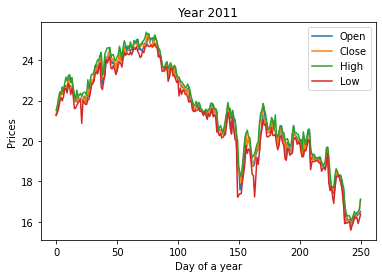

In [6]:
plt.plot(datas['iba'])
plt.legend(['Open','Close','High','Low'])
plt.xlabel('Day of a year')
plt.ylabel('Prices')
plt.title("Year 2011")
# plt.savefig('sample1.png', dpi=200)
plt.show()

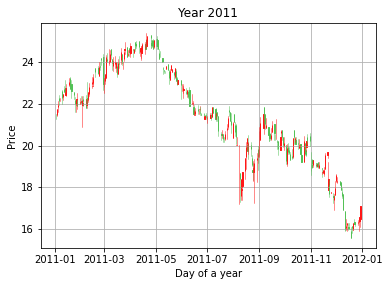

In [73]:
data=pd.read_csv(train_folder+'2011/iba.csv')
data=data.dropna()
# data=data.head(60)

data.Date=pd.to_datetime(data.Date)
data.Date=data.Date.apply(lambda x:date2num(x))
data_mat=data.to_numpy()

fig,ax=plt.subplots()
fig.subplots_adjust(bottom=0.1)
candlestick_ohlc(ax,data_mat,colordown='#53c156', colorup='#ff1717',width=0.3,alpha=1)
ax.grid(True)
ax.xaxis_date()
plt.xlabel('Day of a year')
plt.ylabel('Price')
plt.title('Year 2011')
plt.savefig('kline1.png', dpi=200)
plt.show()

In [24]:
data=pd.read_csv(train_folder+'2011/iba.csv')
data=data.dropna()

In [26]:
data.describe()

,Open,High,Low,Close
count,251.000000,251.000000,251.000000,251.000000
mean,21.340020,21.584582,21.054845,21.338422
std,2.373998,2.347763,2.395209,2.360716
min,15.906000,16.095000,15.594000,15.594000
25%,19.792500,20.075000,19.394000,19.693500
50%,21.499000,21.590000,21.293000,21.464000
75%,23.264500,23.606000,23.033000,23.308500
max,25.305000,25.384000,24.795000,25.270000


In [26]:
#单一变量
processed_data = []
raw_data = []
company = list(datas.keys())
fts = {'mean': sglFts.mean, 'var': sglFts.var, 'std': sglFts.std}
feature_transfomer = FeatureRep(features=fts)
for k in datas.keys():
    #closing price
    data = datas[k][:,1].copy()
    tmp = data[pip(data,150)]
    raw_data.append(tmp)
    #denoising
    data = wavelet_denoising(data)
    #normalising
    # data = zero_mean_normalise(data)
    data = min_max_normalise(data) 
    data = data[pip(data,10)]
    processed_data.append(data)
raw_data = np.array(raw_data)
processed_data = np.array(processed_data)
# processed_data = feature_transfomer.fit_transform(processed_data)

In [49]:
#多变量
pip_dim = 10
processed_data = []
fts = {'mean': sglFts.mean, 'var': sglFts.var, 'std': sglFts.std}
feature_transfomer = FeatureRep(features=fts)
for k in datas.keys():
    #closing price
    shape = datas[k].shape
    data = np.zeros((pip_dim,shape[-1]))
    for i in range(shape[-1]):
        #denoising
        tmp = wavelet_denoising(datas[k][:,i])
        tmp = tmp[pip(tmp,pip_dim)]
        data[:,i]=tmp
    #normalising
    data = min_max_normalise(data)
    processed_data.append(data)
processed_data = np.array(processed_data)
# processed_data = feature_transfomer.fit_transform(processed_data)

In [9]:
num_clusters = 20

In [52]:
ksh = kshape.KShape(n_clusters=num_clusters)
ksh_results = ksh.fit_predict(processed_data)

In [27]:
ac = cluster.AgglomerativeClustering(n_clusters=num_clusters)
ac_results = ac.fit_predict(processed_data)

In [12]:
db = cluster.DBSCAN(eps=0.3, min_samples=3)
db_results = db.fit_predict(processed_data)

In [12]:
def display_patterns(cluster_centers, savename=None):
    center_numbers = len(cluster_centers)
    columns = 4
    rows = math.ceil(center_numbers / columns)
    figure, ax = plt.subplots(rows, columns, dpi=250, figsize=(columns+3,rows+3))
    counter = 0
    for i in range(center_numbers):
        row = int(counter / columns)
        col = counter % columns
        counter += 1
        ax[row, col].axis('off')
        ax[row, col].set_title('Group {}'.format(i+1))
        ax[row, col].plot(cluster_centers[i])
    if savename:
        plt.savefig(savename+'.png', dpi=200)
    plt.show()

def display_groups(data, groups, groupNums):
    columns = 4
    rows = math.ceil(groupNums / columns)
    if rows == 1: rows+=1
    figure, ax = plt.subplots(rows, columns, dpi=250, figsize=(columns+1,rows+1))
    counter = 0
    for i in range(groupNums):
        indexes = groups == i
        row = int(counter / columns)
        col = counter % columns
        counter += 1
        ax[row, col].axis('off')
        ax[row, col].set_title('Group {}'.format(i+1))
        for x in data[indexes]:
            ax[row, col].plot(x,"k-", alpha=.2)
    # plt.savefig('name.png', dpi=200)
    plt.show()
def display_one_group(data,groups,groupId):
    plt.axis('off')
    plt.title('Group {}'.format(groupId+1))
    indexes = groups == groupId
    for x in data[indexes]:
        plt.plot(x)

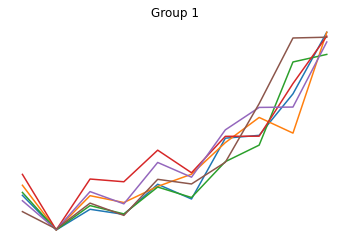

In [16]:
display_one_group(processed_data,db_results,0)

In [ ]:
display_one_group

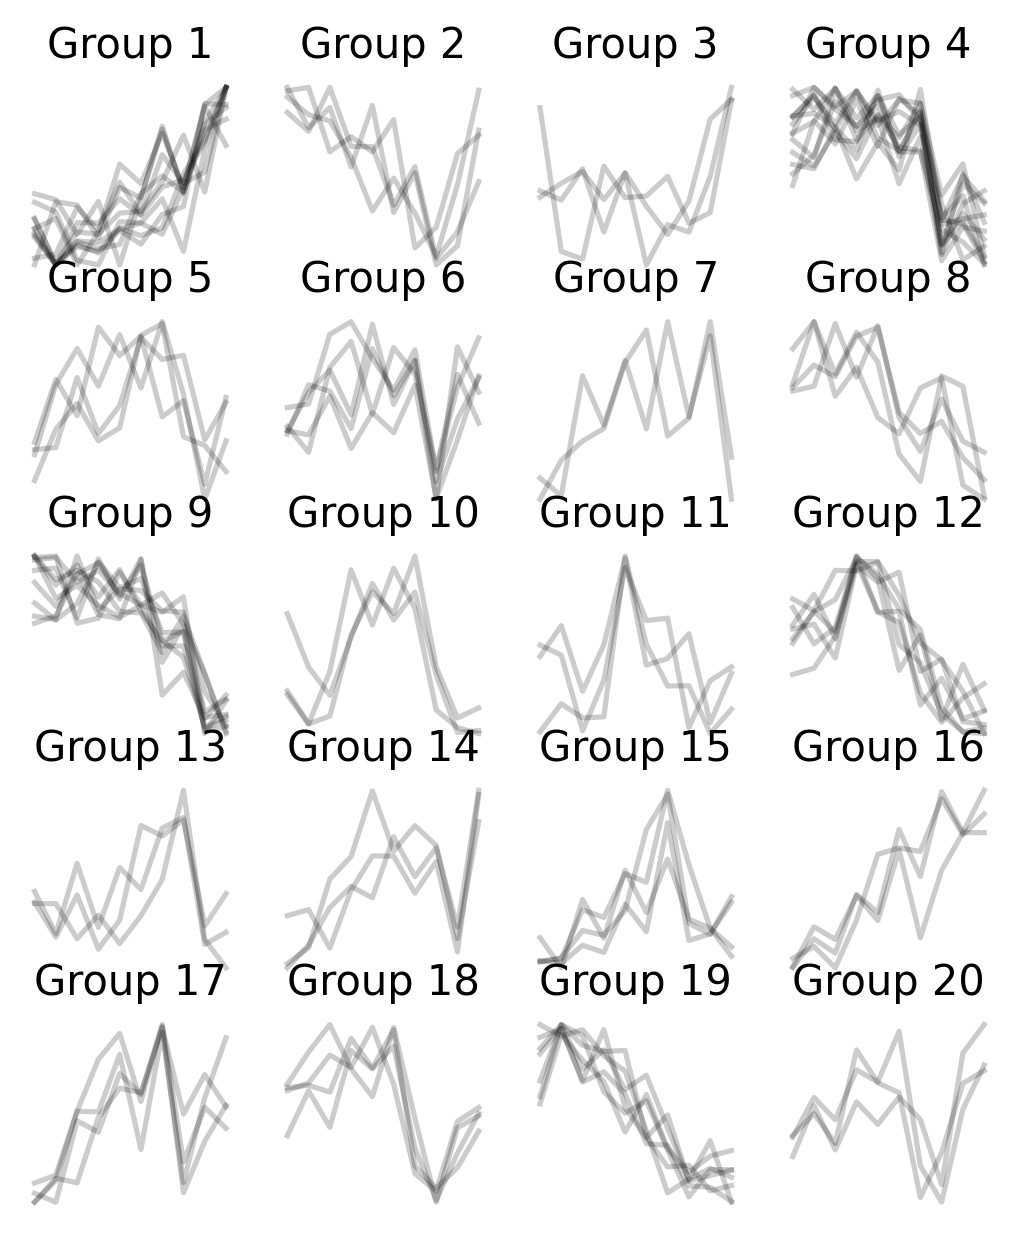

In [28]:
display_groups(processed_data, ac_results, num_clusters)

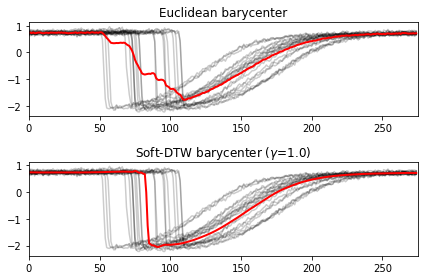

In [2]:
import numpy
import matplotlib.pyplot as plt

from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
from tslearn.datasets import CachedDatasets

# fetch the example data set
numpy.random.seed(0)
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")
X = X_train[y_train == 2]
length_of_sequence = X.shape[1]


def plot_helper(barycenter):
    # plot all points of the data set
    for series in X:
        plt.plot(series.ravel(), "k-", alpha=.2)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r-", linewidth=2)


# plot the four variants with the same number of iterations and a tolerance of
# 1e-3 where applicable
ax1 = plt.subplot(2, 1, 1)
plt.title("Euclidean barycenter")
plot_helper(euclidean_barycenter(X))

# plt.subplot(4, 1, 2, sharex=ax1)
# plt.title("DBA (vectorized version of Petitjean's EM)")
# plot_helper(dtw_barycenter_averaging(X, max_iter=50, tol=1e-3))

# plt.subplot(4, 1, 3, sharex=ax1)
# plt.title("DBA (subgradient descent approach)")
# plot_helper(dtw_barycenter_averaging_subgradient(X, max_iter=50, tol=1e-3))

plt.subplot(2, 1, 2, sharex=ax1)
plt.title("Soft-DTW barycenter ($\gamma$=1.0)")
plot_helper(softdtw_barycenter(X, gamma=1., max_iter=50, tol=1e-3))

# clip the axes for better readability
ax1.set_xlim([0, length_of_sequence])

# show the plot(s)
plt.tight_layout()
plt.savefig('barycenter.png', dpi=200)
plt.show()

In [16]:
ac_index = ac_results == 4

In [15]:
def getNames(nums, indexes):
    ret = []
    for i in range(len(indexes)):
        if indexes[i]: ret.append(nums[i])
    return ret

In [182]:
tmp = list(map(zero_mean_normalise, raw_data[ac_index][[0,2]]))
denoised_tmp = list(map(wavelet_denoising, tmp[:]))
denoised_tmp = np.array(denoised_tmp)
tmp = np.array(tmp)

In [203]:
names =getNames(company, ac_index)

In [162]:
tmp = processed_data[ac_index]

In [187]:
optimal_path, dtw_score = metrics.dtw_path(tmp[0],tmp[1])

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in optimal_path:
    ax.plot([map_x, map_y], [tmp[0][map_x], tmp[1][map_y]], '-k')

ax.plot(tmp[0], marker='o', markersize=10, linewidth=5)
ax.plot(tmp[1], marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

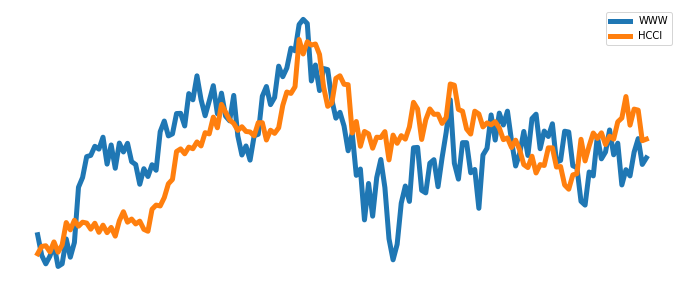

In [224]:

fig, ax = plt.subplots(figsize=(12, 5))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

ax.plot(tmp[0], linewidth=5)
ax.plot(tmp[1], linewidth=5)
ax.legend(['WWW', 'HCCI'])
ax.tick_params(axis="both", which="major", labelsize=18)
fig.savefig('undenoised.png',dpi=200)

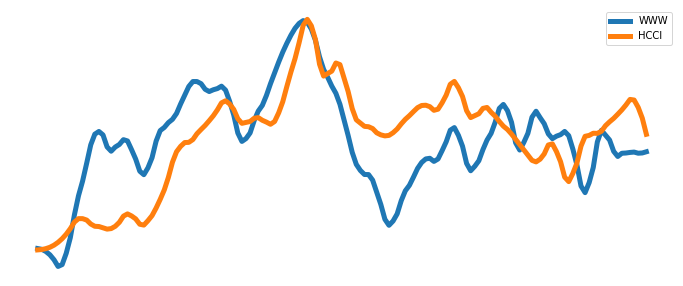

In [225]:
fig, ax = plt.subplots(figsize=(12, 5))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')
ax.legend(['WWW', 'HCCI'])
ax.plot(denoised_tmp[0], linewidth=5)
ax.plot(denoised_tmp[1], linewidth=5)
ax.legend(['WWW', 'HCCI'])
ax.tick_params(axis="both", which="major", labelsize=18)
fig.savefig('denoised.png',dpi=200)

In [231]:
optimal_path, dtw_score = metrics.dtw_path(tmp[0],tmp[1])

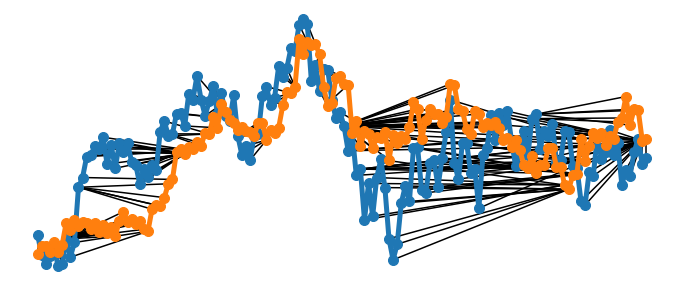

In [227]:

fig, ax = plt.subplots(figsize=(12, 5))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in optimal_path:
    ax.plot([map_x, map_y], [tmp[0][map_x], tmp[1][map_y]], '-k')

ax.plot(tmp[0], marker='o', markersize=10, linewidth=5)
ax.plot(tmp[1], marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)
fig.savefig('undenoised_dtw.png',dpi=200)

In [228]:
optimal_path, dtw_score = metrics.dtw_path(denoised_tmp[0],denoised_tmp[1])

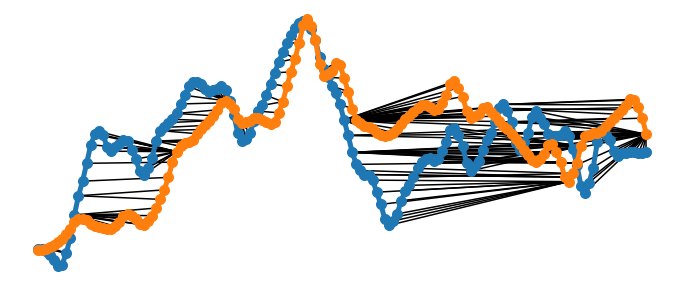

In [229]:
fig, ax = plt.subplots(figsize=(12, 5))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in optimal_path:
    ax.plot([map_x, map_y], [denoised_tmp[0][map_x], denoised_tmp[1][map_y]], '-k')

ax.plot(denoised_tmp[0], marker='o', markersize=10, linewidth=5)
ax.plot(denoised_tmp[1], marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)
fig.savefig('denoised_dtw.png',dpi=200)

In [232]:
dtw_score

5.499433470968542

In [200]:
def distance_compute(a,b):
    dtw = metrics.dtw(a,b)
    cos = spatial.distance.cosine(a,b)
    euclidean = spatial.distance.euclidean(a,b)
    perreson = spatial.distance.correlation(a,b)
    print('dtw: {} cos: {} euclidean: {}, perreson: {}'.format(dtw, cos,euclidean,perreson))

def distance_group(x):
    nums = len(x)
    nums = nums * (nums-1) / 2
    cos = np.triu(spatial.distance.cdist(x,x,'cosine'), 1).sum() / nums
    euclidean =  np.triu(spatial.distance.cdist(x,x), 1).sum() / nums
    perreson = np.triu(spatial.distance.cdist(x,x,'correlation'), 1).sum() / nums
    dtw = np.triu(spatial.distance.cdist(x,x,metrics.dtw), 1).sum() / nums
    print('dtw: {} cos: {} euclidean: {}, perreson: {}'.format(dtw, cos,euclidean,perreson))

In [243]:
distance_compute(*tmp)

cos: 0.4286945232246192 euclidean: 11.34056246256709, perreson: 0.4286945232246192


In [244]:
distance_compute(*denoised_tmp)

cos: 0.38985428723218873 euclidean: 10.45556560017796, perreson: 0.38985375626860863


In [275]:
ac_index = ac_results == 6
tmp = list(map(zero_mean_normalise, raw_data[ac_index]))
denoised_tmp = list(map(wavelet_denoising, tmp[:]))
denoised_tmp = np.array(denoised_tmp)
tmp = np.array(tmp)

In [272]:
distance_group(tmp)

dtw: 3.441697625301907 cos: 0.16848905203232573 euclidean: 6.743431890886533, perreson: 0.16848905203232586


In [276]:
distance_group(denoised_tmp)

dtw: 3.3823938757970327 cos: 0.16146491102613075 euclidean: 6.5415309284490375, perreson: 0.16146476668711443


In [274]:
def wavelet_denoising(data):
    '''
    Denoising data 
    '''
    db4 = pywt.Wavelet('db8')
    coeffs = pywt.wavedec(data, db4)
    # coeffs[len(coeffs)-1] *= 0
    # coeffs[len(coeffs)-2] *= 0
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], 0.04)
    meta = pywt.waverec(coeffs, db4)
    return meta


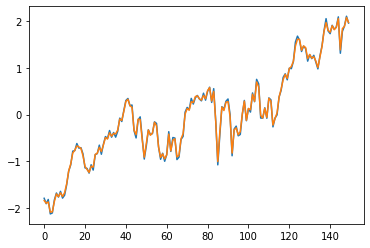

In [278]:
plt.plot(tmp[0])
plt.plot(denoised_tmp[0])

In [10]:
iba = datas['iba'][:,0]
min_max_iba = min_max_normalise(iba)
zere_iba = zero_mean_normalise(iba)

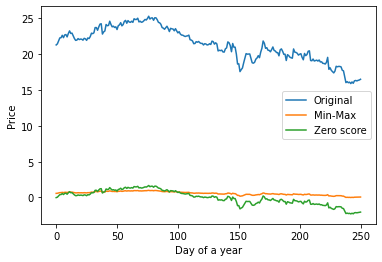

In [13]:
plt.plot(iba)
plt.plot(min_max_iba)
plt.plot(zere_iba)
plt.xlabel('Day of a year')
plt.ylabel('Price')
plt.legend(['Original', 'Min-Max', 'Zero score'])

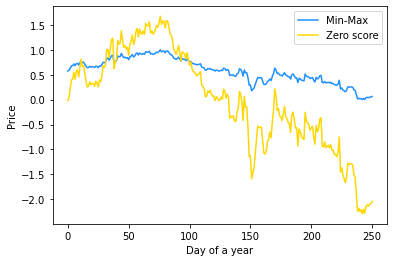

In [31]:
plt.plot(min_max_iba, c='dodgerblue')
plt.plot(zere_iba,c='gold')
plt.xlabel('Day of a year')
plt.ylabel('Price')
plt.legend(['Min-Max', 'Zero score'])
plt.savefig('minzero.png')

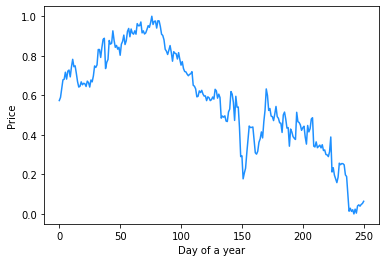

In [32]:
plt.plot(min_max_iba,c='dodgerblue')
plt.xlabel('Day of a year')
plt.ylabel('Price')
plt.savefig('minmax.png',dpi=200)

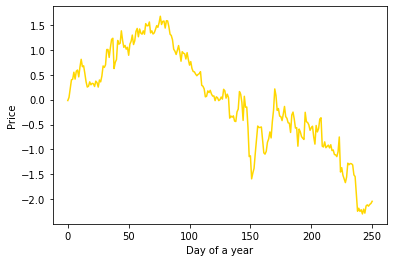

In [33]:
plt.plot(zere_iba, c='gold')
plt.xlabel('Day of a year')
plt.ylabel('Price')
plt.savefig('zmeans.png',dpi=200)

In [58]:
time1 = np.linspace(start=0, stop=1, num=50)
# time2 = time1[0:40]

x1 = 2 * np.sin(np.pi * time1) + 1.5 * np.sin(4*np.pi * time1)
x2 = 1.5 * x1 + 10

In [196]:
percentage = 0.25
# sample_num = int(len(iba) * percentage)
sample_num = 50

In [197]:
linear_sample = preprocessing.TimeSeriesResampler(sample_num)
paa_trans = PiecewiseAggregateApproximation(output_size=sample_num, window_size=None ,overlapping=False)
ts_paa = piecewise.PiecewiseAggregateApproximation(n_segments=sample_num)

In [216]:
pip_iba_50 = iba[pip(iba,sample_num)]
linear_sampling = linear_sample.fit_transform(iba)
ts_paa_50 = ts_paa.fit_transform(iba.reshape(1,-1,1))
# paa = paa_trans.fit_transform(iba.reshape(1,-1))

In [213]:
iba.shape

(251,)

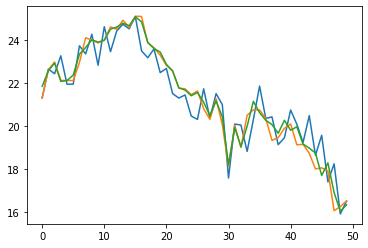

In [170]:
plt.plot(pip_iba_50)
plt.plot(linear_sampling.ravel())
plt.plot(ts_paa_50.ravel())

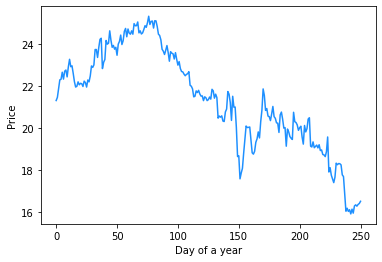

In [176]:
plt.plot(iba, c='dodgerblue')
plt.xlabel("Day of a year")
plt.ylabel("Price")
plt.savefig('iba2.png',dpi=200)

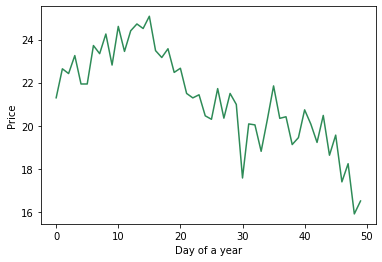

In [178]:
plt.plot(pip_iba_50, c='seagreen')
plt.xlabel("Day of a year")
plt.ylabel("Price")
plt.savefig('pip_iba_50.png',dpi=200)

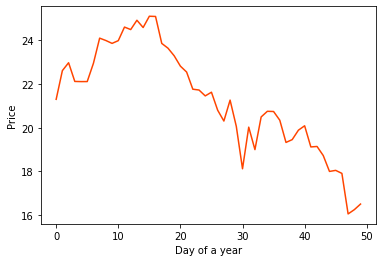

In [181]:
plt.plot(linear_sampling.ravel(), c='orangered')
plt.xlabel("Day of a year")
plt.ylabel("Price")
plt.savefig('linear_sampling.png',dpi=200)

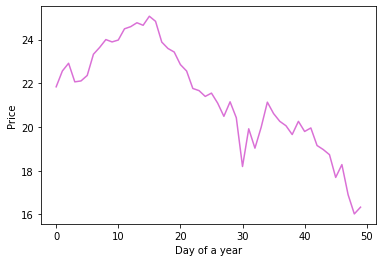

In [187]:
plt.plot(ts_paa_50.ravel(), c='orchid')
plt.xlabel("Day of a year")
plt.ylabel("Price")
plt.savefig('ppa_50.png',dpi=200)

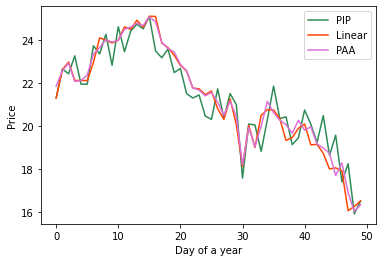

In [186]:
plt.plot(pip_iba_50, c='seagreen')
plt.plot(linear_sampling.ravel(), c='orangered')
plt.plot(ts_paa_50.ravel(), c='orchid')
plt.legend(['PIP','Linear','PAA'])
plt.xlabel("Day of a year")
plt.ylabel("Price")
plt.savefig('pippaacompare1.png',dpi=200)

In [205]:
s1 = datas['www'][:,1]
s2 = datas['hcci'][:,1]

In [217]:
def comparition(x,y,n=50):
    downsample = preprocessing.TimeSeriesResampler(n)
    ts_paa = piecewise.PiecewiseAggregateApproximation(n_segments=sample_num)
    
    x_pip = x[pip(x,n)]
    x_down_sample = linear_sample.fit_transform(x).ravel()
    x_paa = ts_paa.fit_transform(x.reshape(1,-1,1)).ravel()

    y_pip = y[pip(y,n)]
    y_down_sample = linear_sample.fit_transform(y).ravel()
    y_paa = ts_paa.fit_transform(y.reshape(1,-1,1)).ravel()
    
    print('PIP')
    distance_compute(x_pip,y_pip)
    print('Downsample')
    distance_compute(x_down_sample,y_down_sample)
    print('PAA')
    distance_compute(x_paa,y_paa)

In [218]:
comparition(s1,s2)

PIP
dtw: 11.8506134440374 cos: 0.010937588692042421 euclidean: 17.86186317269282, perreson: 0.35038428459826587
Downsample
dtw: 12.101443298426831 cos: 0.011235065498199526 euclidean: 18.693266392937257, perreson: 0.3273212698100795
PAA
dtw: 11.747177049827753 cos: 0.01066060487831988 euclidean: 18.280702109054783, perreson: 0.3452215894595434


In [47]:
def distance_group2(names, n, denoising=False):
    x_down_samples = []
    x_pips = []
    x_pass = []
    downsample = preprocessing.TimeSeriesResampler(n)
    ts_paa = piecewise.PiecewiseAggregateApproximation(n_segments=n)
    for name in names:
        y = datas[name][:,1]
        if denoising:
            y = min_max_normalise(y)
            y = wavelet_denoising(y)
        y_pip = y[pip(y,n)]
        x_pips.append(y_pip)
        y_down_sample = downsample.fit_transform(y).ravel()
        x_down_samples.append(y_down_sample)
        y_paa = ts_paa.fit_transform(y.reshape(1,-1,1)).ravel()
        x_pass.append(y_paa)
    x_down_samples = np.array(x_down_samples)
    x_pips = np.array(x_pips)
    x_pass = np.array(x_pass)

    for x in (x_down_samples,x_pips,x_pass):
        nums = len(x)
        nums = nums * (nums-1) / 2
        cos = np.triu(spatial.distance.cdist(x,x,'cosine'), 1).sum() / nums
        euclidean =  np.triu(spatial.distance.cdist(x,x), 1).sum() / nums
        perreson = np.triu(spatial.distance.cdist(x,x,'correlation'), 1).sum() / nums
        dtw = np.triu(spatial.distance.cdist(x,x,metrics.dtw), 1).sum() / nums
        # print('dtw: {} cos: {} euclidean: {}, perreson: {}'.format(dtw, cos,euclidean,perreson))
        print(r'{:.3f} & {:.3f} & {:.3f} & {:.3f} \\ \hline'.format(dtw, cos,euclidean,perreson))